In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from pathlib import Path
import seaborn as sns
import networkx as nx 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, zero_one_loss, log_loss, accuracy_score, f1_score, precision_score,classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import zero_one_loss

Soft 0 to 17.1, Slightly Hard 17.1 to 60, Moderately Hard 60 to 120, hard >120 to 180 Very Hard > 180
(Source: Lehr, J. et. al., 1980. Domestic Water Treatment, New York, NY: McGraw-Hill Book Company - Note: This is a great desk reference if you can find it.)

For missing values of Ph level hardness will be used to determine appropriate value. 

When people consume trihalomethanes at high levels over many years, they increase their risk of developing bladder cancer. Other health effects that may be associated with trihalomethanes include rectal and colon cancer, and adverse developmental and reproductive effects during pregnancy. They have been studied with mixed results; however, the weight of evidence of the health effects data suggests a potential association. [https://tracking.idph.iowa.gov/Environment/Public-Drinking-Water/Public-Water-and-Health/TTHM-in-Public-Water-and-Health]

hard non-potable: [7.35717303]
hard potable: [7.12055497]
soft non-potable: [6.816154]
soft potable: [7.02571959]
high non-potable: [363.42834086]
high potable: [371.30721111]
low non-potable: [306.45485401]
low potable: [296.04267943]
shape: (3276, 10)
         ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0  7.357173  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246  363.428341    592.885359   
2  8.099124  224.236259  19909.541732     9.275884  363.428341    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       1

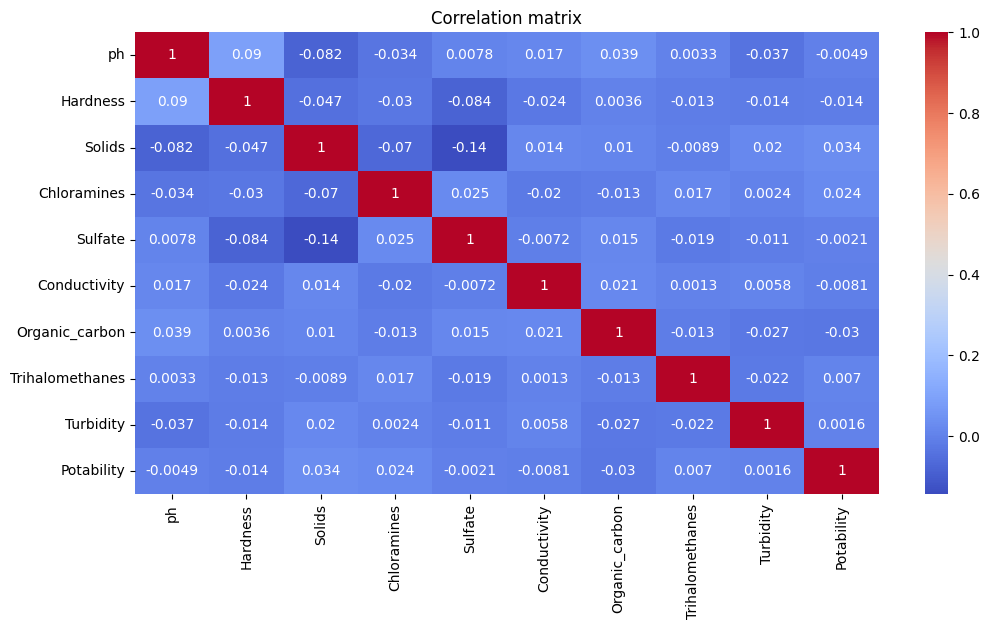

In [ ]:
data_path = "water_potability.csv"
df = pd.read_csv(data_path)

# Replace NaN values with 0 for 'Potability' column and with mean for other columns
df['Potability'] = df['Potability'].fillna(0)

hard_nonpotable=df[(df['Hardness']>196.967627) & (df['Potability']==0)][['ph']].mean()
hard_potable=df[(df['Hardness']>196.967627) & (df['Potability']==1)][['ph']].mean()
soft_nonpotable=df[(df['Hardness']<=196.967627) & (df['Potability']==0)][['ph']].mean()
soft_potable=df[(df['Hardness']<=196.967627) & (df['Potability']==1)][['ph']].mean()

print(f"""hard non-potable: {hard_nonpotable.values}\nhard potable: {hard_potable.values}
soft non-potable: {soft_nonpotable.values}\nsoft potable: {soft_potable.values}""")

df.loc[(df['Hardness']>196.967627) & (df['Potability']==0) & (df['ph'].isnull()), 'ph'] = [hard_nonpotable]
df.loc[(df['Hardness']>196.967627) & (df['Potability']==1) & (df['ph'].isnull()), 'ph'] = [hard_potable]
df.loc[(df['Hardness']<=196.967627) & (df['Potability']==0) & (df['ph'].isnull()), 'ph'] = [soft_nonpotable]
df.loc[(df['Hardness']<=196.967627) & (df['Potability']==1) & (df['ph'].isnull()), 'ph'] = [soft_potable]

nonpotable_highsulfate=df[(df['Sulfate']>333.775777) & (df['Potability']==0)][['Sulfate']].mean()
potable_highsulfate=df[(df['Sulfate']>333.775777) & (df['Potability']==1)][['Sulfate']].mean()
nonpotable_lowsulfate=df[(df['Sulfate']<=333.775777) & (df['Potability']==0)][['Sulfate']].mean()
potable_lowsulfate=df[(df['Sulfate']<=333.775777) & (df['Potability']==1)][['Sulfate']].mean()

print(f"""high non-potable: {nonpotable_highsulfate.values}\nhigh potable: {potable_highsulfate.values}
low non-potable: {nonpotable_lowsulfate.values}\nlow potable: {potable_lowsulfate.values}""")


df.loc[(df['Potability']==0) & (df['Sulfate'].isnull()), 'Sulfate'] = [nonpotable_highsulfate]
df.loc[(df['Potability']==1) & (df['Sulfate'].isnull()), 'Sulfate'] = [potable_highsulfate]
df.loc[(df['Potability']==0) & (df['Sulfate'].isnull()), 'Sulfate'] = [nonpotable_lowsulfate]
df.loc[(df['Potability']==1) & (df['Sulfate'].isnull()), 'Sulfate'] = [potable_lowsulfate]

df = df.fillna(df.mean())
print(f"shape: {np.shape(df)}")

# Display the first few rows of the DataFrame
print(df.head())

print("\nThe first 5 rows of the dataset, Potability is our label value and the rest are features")
print("Lets plot a correlation matrix of the dataset to see how features corralate with label value")

# Correlation matrix of the dataset
corr_matrix = df.corr()

plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation matrix")
plt.show()

In [ ]:
# Split the dataset into 5 local dataets based on ph values
df['local_datasets'] = pd.cut(df['ph'], bins=5)

# Number of data points in each local dataset
local_datasets = df['local_datasets'].value_counts()

print("The number of data points in each local dataset; \n")
for ranges, num in local_datasets.items():
    print(f"Range of pH: {ranges}, Number of data points: {num}")

The number of data points in each local dataset; 

Range of pH: (5.6, 8.4], Number of data points: 2304
Range of pH: (8.4, 11.2], Number of data points: 498
Range of pH: (2.8, 5.6], Number of data points: 437
Range of pH: (11.2, 14.0], Number of data points: 21
Range of pH: (-0.014, 2.8], Number of data points: 16


In [ ]:
# Splitting each local dataet into training, testing and validation sets accordingly to 60-20-20 split
all_data = {}

for sets, data in df.groupby('local_datasets'):
    X = data.drop('Potability', axis=1)  # Features
    y = data['Potability']               # label
    
    # 60-20-20 split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)
    
    train = pd.concat([X_train, y_train], axis=1)
    test = pd.concat([X_test, y_test], axis=1)
    validation = pd.concat([X_val, y_val], axis=1)
    
    # all sets to dictionary
    all_data[sets] = {
        'Train': train,
        'Test': test,
        'Validation': validation
    }
    
    print(f"Range of pH: {sets}")
    print(f"Training set datapoints: {len(train)}, Testing set datapoints: {len(test)} Validation set datapoints: {len(validation)}")
    print()

Range of pH: (-0.014, 2.8]
Training set datapoints: 9, Testing set datapoints: 3 Validation set datapoints: 4

Range of pH: (2.8, 5.6]
Training set datapoints: 262, Testing set datapoints: 87 Validation set datapoints: 88

Range of pH: (5.6, 8.4]
Training set datapoints: 1382, Testing set datapoints: 461 Validation set datapoints: 461

Range of pH: (8.4, 11.2]
Training set datapoints: 298, Testing set datapoints: 100 Validation set datapoints: 100

Range of pH: (11.2, 14.0]
Training set datapoints: 12, Testing set datapoints: 4 Validation set datapoints: 5



Number of y_train datapoints: 9
Graph feature shape: (9, 9)


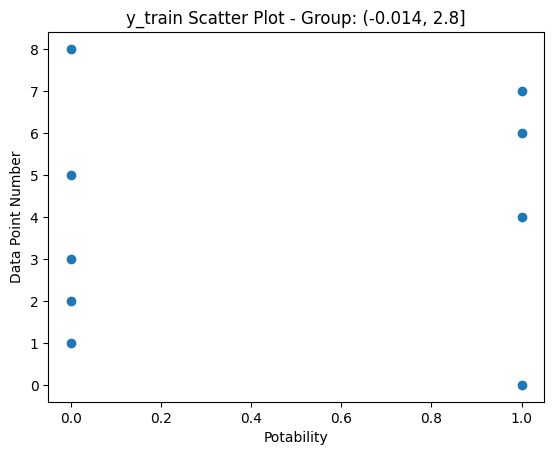

Number of y_train datapoints: 262
Graph feature shape: (262, 9)


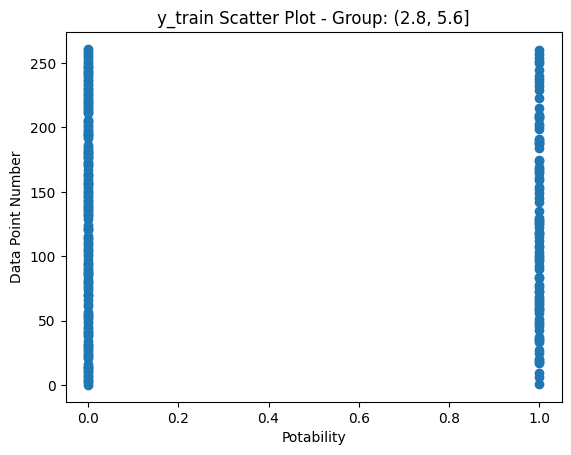

Number of y_train datapoints: 1382
Graph feature shape: (1382, 9)


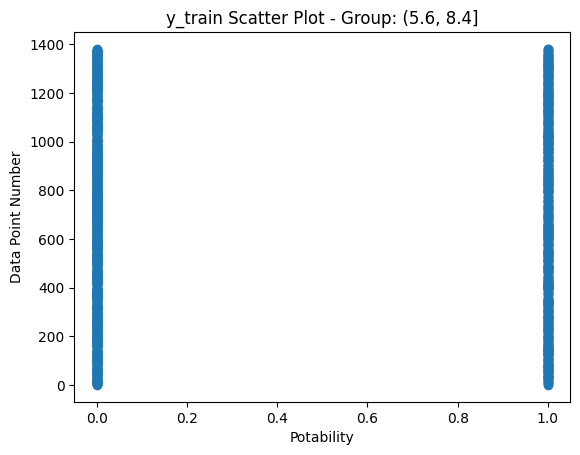

Number of y_train datapoints: 298
Graph feature shape: (298, 9)


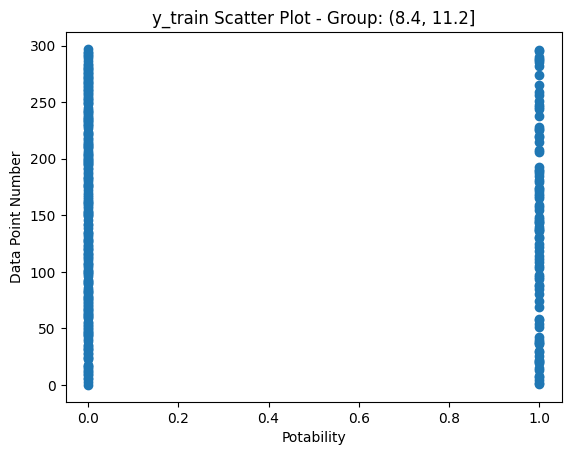

Number of y_train datapoints: 12
Graph feature shape: (12, 9)


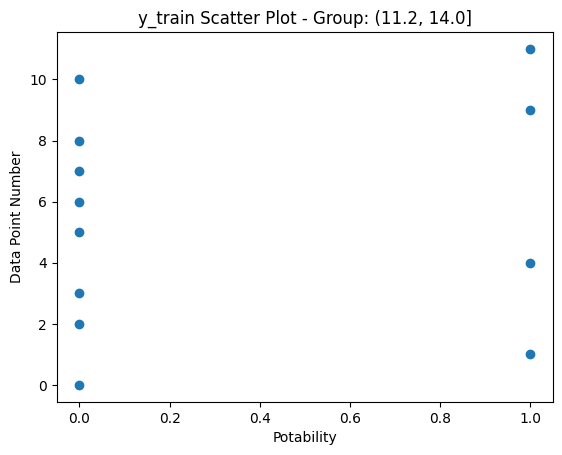

In [ ]:
Gin = nx.Graph()
i = 0

X_T = []
Y_T = []
X_TE = []
Y_TE = []
X_V = []
Y_V = []


for name, sets in all_data.items():
    train = sets['Train']
    test = sets['Test']
    validation = sets['Validation']
    
    # Drop the 'local_datasets' column split
    train = train.drop('local_datasets', axis=1)
    test = test.drop('local_datasets', axis=1)
    validation = validation.drop('local_datasets', axis=1)
    
    X_train = train.drop('Potability', axis=1)  # Features
    y_train = train['Potability']  # label
    
    X_T.append(X_train.values.tolist())
    Y_T.append(y_train.values.tolist())
    
    X_TE.append(test.drop('Potability', axis=1).values.tolist())
    Y_TE.append(test['Potability'].values.tolist())
    
    X_V.append(validation.drop('Potability', axis=1).values.tolist())
    Y_V.append(validation['Potability'].values.tolist())

    print("Number of y_train datapoints:", len(X_train.values.tolist()))
    
    Gin.add_node(i) 
    Gin.nodes[i]['name'] = name
    Gin.nodes[i]['X'] = X_train.to_numpy()
    Gin.nodes[i]['y'] = y_train.to_numpy().reshape(-1,1)
    
    print(f"Graph feature shape: {np.shape(Gin.nodes[i]['X'])}")

    # Scatter plot of the y_train values
    plt.scatter(train['Potability'], range(len(train)))

    plt.title(f"y_train Scatter Plot - Group: {name}")
    plt.xlabel("Potability")
    plt.ylabel("Data Point Number")

    # Display the plot
    plt.show()
    
    i = i + 1


In [ ]:
# Using FedSGD to learn weights for each node/local dataset

def FedSGD(Gin,lrate=0.01,regparam=0,maxiter=100):
# init model parmas (weights of linear maps) to zero 

    for node_i in Gin.nodes(data=False): 
        # determine number of features used to characterize data points 
        # this nr. of features is equal to the length of the weight vector
        print(np.shape(Gin.nodes[node_i]["X"]))
        print(np.shape(Gin.nodes[node_i]["y"]))
        nrfeatures = Gin.nodes[node_i]["X"].shape[1]
        Gin.nodes[node_i]["w"] = np.zeros((nrfeatures,1))

    for iter_GD in range(maxiter):

    # the following "for loop" computes the local gradient at each node 
        for node_i in Gin.nodes(data=False):
            tmp_y = Gin.nodes[node_i]["y"].reshape(-1,1)
            tmp_X = Gin.nodes[node_i]["X"]
            localsamplesize = tmp_X.shape[0]
            currw = Gin.nodes[node_i]["w"]
            tmp_vec = np.zeros(currw.shape)
            for node_j in Gin[node_i]: 
                tmp_vec += (currw - Gin.nodes[node_j]["w"])
            
            update = (1/localsamplesize)*tmp_X.T.dot(tmp_y-tmp_X.dot(currw))-regparam*tmp_vec  
            
            # we need to store the updated weights in a dummy attribute 
            # as we need to use current weights for the updates of other nodes 
            Gin.nodes[node_i]["w_new"] = Gin.nodes[node_i]["w"]+2*lrate*update
        for node_i in Gin.nodes(data=False): 
            Gin.nodes[node_i]["w"] =  Gin.nodes[node_i]["w_new"]



In [ ]:
# Adding nodes to the networkx graph Gin

Gin.add_edge(1, 2)
Gin.add_edge(0, 3)
Gin.add_edge(4, 2)

FedSGD(Gin, lrate=0.0000000001, regparam=10, maxiter=8000)


print(Gin.nodes.data("name"))

(9, 9)
(9, 1)
(262, 9)
(262, 1)
(1382, 9)
(1382, 1)
(298, 9)
(298, 1)
(12, 9)
(12, 1)
[(0, Interval(-0.014, 2.8, closed='right')), (1, Interval(2.8, 5.6, closed='right')), (2, Interval(5.6, 8.4, closed='right')), (3, Interval(8.4, 11.2, closed='right')), (4, Interval(11.2, 14.0, closed='right'))]


In [ ]:
for node_iterator in Gin.nodes():
    print(np.shape(Gin.nodes.data('w')[node_iterator]))
# Shape should be (9,1)

(9, 1)
(9, 1)
(9, 1)
(9, 1)
(9, 1)


In [ ]:
# logistic regression
import warnings
import numpy as np

train_err_list = []
test_err_list = []
val_err_list = []
avg_train_err_list = []
avg_test_err_list = []
avg_val_err_list = []

with warnings.catch_warnings():
    #warnings.filterwarnings("ignore", category=UserWarning)
    #warnings.filterwarnings("ignore", category=FutureWarning)

    for i, node in enumerate(Gin.nodes()):
        localmodel = Gin.nodes[node]['w']
        weight = Gin.nodes.data('w')[node]
        weight = weight.flatten()
        weight = np.array(weight)
        
        class_weights = {}

        unique_labels = np.unique(Y_T[i])

        for label in unique_labels:
            if label in Y_T[i]:
                class_weights[label] = weight[label]
            else:
                class_weights[label] = 0
                
        log_model = LogisticRegression(random_state=0, class_weight=class_weights, max_iter=1000)

        
        min_max_scaler = preprocessing.MinMaxScaler()
        X_train_minmax = min_max_scaler.fit_transform(X_train)
        
        log_model.fit(X_T[i], Y_T[i])
        
        # TRAIN
        train_pred_proba = log_model.predict_proba(X_T[i])
        train_pred = log_model.predict(X_T[i])
        train_err = log_loss(Y_T[i], train_pred, labels=unique_labels)
        train_err_list.append(train_err)
        avg_train_err_list.append(accuracy_score(Y_T[i], train_pred))
        
        # TEST
        X_test = min_max_scaler.fit_transform(X_TE[i])
        test_pred_proba = log_model.predict_proba(X_test)
        test_pred = log_model.predict(X_test)
        test_err = log_loss(Y_TE[i], test_pred, labels=unique_labels)
        test_err_list.append(test_err)
        avg_test_err_list.append(accuracy_score(Y_TE[i], test_pred))
        
        # Val
        X_val = min_max_scaler.fit_transform(X_V[i])
        val_pred_proba = log_model.predict_proba(X_val)
        val_pred = log_model.predict(X_val)
        val_err = log_loss(Y_V[i], val_pred, labels=unique_labels)
        val_err_list.append(val_err)
        avg_val_err_list.append(accuracy_score(Y_V[i], val_pred))
        
        print("NODE: ", i)
        print("Train log loss: ", train_err)
        print("Test log loss: ", test_err)
        print("Validation log loss: ", val_err)
        print(f"Validation accuracy: {log_model.score(X_V[i], Y_V[i])}")
        print(f"Test accuracy: {log_model.score(X_TE[i], Y_TE[i])}")
        print()
        #print(classification_report(test_pred, Y_TE[i],zero_division=1))

print()        
print(f"Training accuracy average: {np.mean(avg_train_err_list)}")
print(f"Test accuracy average: {np.mean(avg_test_err_list)}")
print(f"Validation accuracy average: {np.mean(avg_val_err_list)}")
print("Average Train Log Loss:", np.mean(train_err_list))
print("Average Test Log Loss:", np.mean(test_err_list))
print("Average Validation Log Loss:", np.mean(val_err_list))
#print(f"Train pred proba: {train_pred_proba}")


NODE:  0
Train log loss:  16.019401506274292
Test log loss:  2.2204460492503136e-16
Validation log loss:  9.010913347279288

NODE:  1
Train log loss:  23.249532147941977
Test log loss:  26.514871458660885
Validation log loss:  22.11769639786734

NODE:  2
Train log loss:  21.438410337087046
Test log loss:  20.95379416113535
Validation log loss:  20.719236763809203

NODE:  3
Train log loss:  11.006618987951882
Test log loss:  14.05702482175569
Validation log loss:  14.05702482175569

NODE:  4
Train log loss:  12.014551129705717
Test log loss:  2.2204460492503136e-16
Validation log loss:  7.20873067782343


Training accuracy average: 0.5354049535153863
Test accuracy average: 0.6586045827411674
Validation accuracy average: 0.5943052652336818
Average Train Log Loss: 16.745702821792186
Average Test Log Loss: 12.305138088310384
Average Validation Log Loss: 14.62272040170699


In [ ]:
# DecisionTreeClassifier

AVG_TRAIN = 0
AVG_TEST = 0
AVG_VAL = 0
train_acc_tree = []
test_acc_tree = []
val_acc_tree = []

i = 0

import warnings
from sklearn.tree import DecisionTreeClassifier

with warnings.catch_warnings():
    # warnings.filterwarnings("ignore", category=UserWarning)
    # warnings.filterwarnings("ignore", category=FutureWarning)
    for node in Gin.nodes():
        localmodel = Gin.nodes[node]['w']
        weight = Gin.nodes.data('w')[node]
        weight = weight.flatten()
        tree_model = DecisionTreeClassifier()

        weight = np.repeat(weight, len(X_T[i]) // len(weight))
        if len(weight) < len(X_T[i]):
            weight = np.concatenate((weight, np.repeat(weight[-1], len(X_T[i]) - len(weight))))
        
        # TRAIN
        tree_model.fit(X_T[i], Y_T[i], sample_weight=weight)
        train_pred = tree_model.predict_proba(X_T[i])
        train_acc_tree.append(accuracy_score(Y_T[i], tree_model.predict(X_T[i])))
        # TEST
        test_pred = tree_model.predict_proba(X_TE[i])
        tree_nonprob = tree_model.predict(X_TE[i])
        test_acc_tree.append(accuracy_score(Y_TE[i], tree_model.predict(X_TE[i])))
        # Val
        val_pred = tree_model.predict_proba(X_V[i])
        val_acc_tree.append(accuracy_score(Y_V[i], tree_model.predict(X_V[i])))
        
        print("NODE:", i)
        print("Log loss Train: ", log_loss(Y_T[i], train_pred, labels=unique_labels))
        print("Log loss Test: ", log_loss(Y_TE[i], test_pred, labels=unique_labels))
        print("Log loss Validation: ", log_loss(Y_V[i], val_pred, labels=unique_labels))
        print(f"Validation accuracy: {log_model.score(X_V[i], Y_V[i])}")
        print(f"Test accuracy: {log_model.score(X_TE[i], Y_TE[i])}")
        AVG_TRAIN = AVG_TRAIN + log_loss(Y_T[i], train_pred, labels=unique_labels)
        AVG_TEST = AVG_TEST + log_loss(Y_TE[i], test_pred, labels=unique_labels)
        AVG_VAL = AVG_VAL + log_loss(Y_V[i], val_pred, labels=unique_labels)
        print()
        #print(classification_report(tree_nonprob, Y_TE[i]))
        i = i + 1
        
print("Average train Log Loss:", AVG_TRAIN / 5)
print("Average test Log Loss:", AVG_TEST / 5)
print("Average validation Log Loss:", AVG_VAL / 5)
print(f"Training accuracy avarage: {np.mean(train_acc_tree)}")
print(f"Test accuracy avarage: {np.mean(test_acc_tree)}")
print(f"Validation accuracy avarage: {np.mean(val_acc_tree)}")



NODE: 0
Log loss Train:  12.014551129705717
Log loss Test:  24.029102259411435
Log loss Validation:  18.021826694558577

NODE: 1
Log loss Train:  2.2204460492503136e-16
Log loss Test:  7.457307597748376
Log loss Validation:  7.782152436286657

NODE: 2
Log loss Train:  2.2204460492503136e-16
Log loss Test:  10.94601187521996
Log loss Validation:  9.616853290371823

NODE: 3
Log loss Train:  8.224726276711296
Log loss Test:  13.336151753973347
Log loss Validation:  12.25484215229983

NODE: 4
Log loss Train:  12.014551129705717
Log loss Test:  2.2204460492503136e-16
Log loss Validation:  7.20873067782343

Average train Log Loss: 6.450765707224546
Average test Log Loss: 11.153714697270624
Average validation Log Loss: 10.976881050268064
Training accuracy avarage: 0.8210290827740492
Test accuracy avarage: 0.6905498292068716
Validation accuracy avarage: 0.6954559258528891
